In [ ]:
import random
import nobrainer
import os, sys
sys.path.append('..')
import numpy as np
import nibabel as nb
from glob import glob


import defacing
from defacing import dataloaders, training

(8, 128, 128, 1) [[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]
<RepeatDataset shapes: ((None, 128, 128, 1), (None, 1)), types: (tf.float32, tf.float32)>
(8, 128, 128, 1) [[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]
<RepeatDataset shapes: ((None, 128, 128, 1), (None, 1)), types: (tf.float32, tf.float32)>
(8, 128, 128, 1) [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]
<RepeatDataset shapes: ((None, 128, 128, 1), (None, 1)), types: (tf.float32, tf.float32)>


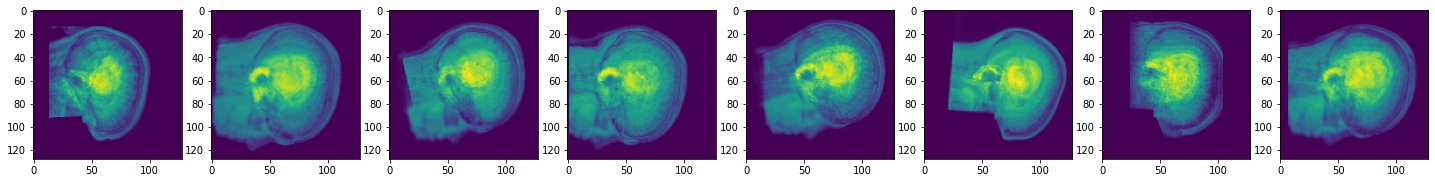

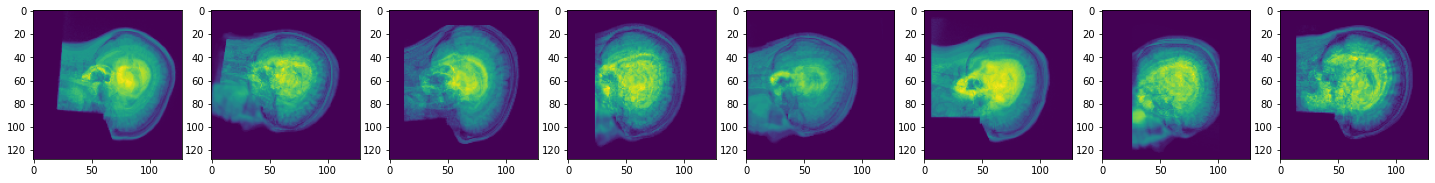

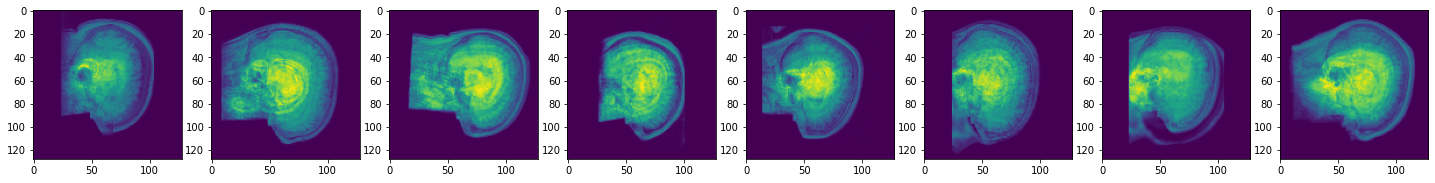

In [14]:
import nobrainer
from nobrainer.io import _is_gzipped
from nobrainer.volume import to_blocks
import sys, os
sys.path.append('../')
from defacing.preprocessing.augmentation import VolumeAugmentations, SliceAugmentations
from defacing.helpers.utils import load_vol
import tensorflow as tf
import glob
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_dataset(
    file_pattern,
    n_classes,
    batch_size,
    volume_shape,
    plane,
    n_slices = 24,
    block_shape=None,
    n_epochs=None,
    mapping=None,
    shuffle_buffer_size=None,
    num_parallel_calls=AUTOTUNE,
    mode='train',
):

    """ Returns tf.data.Dataset after preprocessing from
    tfrecords for training and validation

    Parameters
    ----------
    file_pattern:

    n_classes:
    """

    files = glob.glob(file_pattern)

    if not files:
        raise ValueError("no files found for pattern '{}'".format(file_pattern))

    compressed = _is_gzipped(files[0])
    shuffle = bool(shuffle_buffer_size)

    ds = nobrainer.dataset.tfrecord_dataset(
        file_pattern=file_pattern,
        volume_shape=volume_shape,
        shuffle=shuffle,
        scalar_label=True,
        compressed=compressed,
        num_parallel_calls=num_parallel_calls,
    )
    
    
    def _ss(x, y):
        
        x, y = structural_slice(x, y, plane, n_slices)
        return (x, y)
    
    
    ds = ds.map(_ss, num_parallel_calls)
        
    ds = ds.prefetch(buffer_size=batch_size)
    
    if batch_size is not None:
        ds = ds.batch(batch_size=batch_size, drop_remainder=False)
        
    if mode == 'train':
        if shuffle_buffer_size:
            ds = ds.shuffle(buffer_size=shuffle_buffer_size)

#         Repeat the dataset n_epochs times
        ds = ds.repeat(n_epochs)

    return ds


def structural_slice(x, y, plane, n_slices = 4):

    """ Transpose dataset based on the plane

    Parameters
    ----------
    x:

    y:

    plane:
    
    n:

    augment:
    """

    options = ["sagittal", "coronal", "axial", "combined"]
    shape = np.array(x.shape)
    if isinstance(plane, str) and plane in options:
        idxs = np.random.randint(x.shape[0], size=(n_slices, 3))
#         idxs = np.array([[64, 64, 64]])
        if plane == "sagittal":
            midx = idxs[:, 0]
            x = x

        if plane == "coronal":
            midx = idxs[:, 1]
            x = tf.transpose(x, perm=[1, 2, 0])


        if plane == "axial":
            midx = idxs[:, 2]
            x = tf.transpose(x, perm=[2, 0, 1])


        if plane == "combined":
            temp = {}
            for op in options[:-1]:
                temp[op] = structural_slice(x, y, op, n_slices)[0]
            x = temp

        if not plane == "combined":
            x = tf.squeeze(tf.gather_nd(x, midx.reshape(n_slices, 1, 1)), axis=1)
            x = tf.math.reduce_mean(x, axis=0)
            x = tf.expand_dims(x, axis=-1)
            x = tf.convert_to_tensor(x)
        return x, y
    else:
        raise ValueError("expected plane to be one of [sagittal, coronal, axial]")


if __name__ == "__main__":
    ROOTDIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128/tfrecords_full'
    n_classes = 2
    global_batch_size = 8
    volume_shape = (128, 128, 128)
    ds = get_dataset(
        os.path.join(ROOTDIR, "data-train_*"),
        n_classes=n_classes,
        batch_size=global_batch_size,
        volume_shape=volume_shape,
        plane="sagittal",
        shuffle_buffer_size=3,
    )
    
    import matplotlib.pyplot as plt

    # x, y = next(ds.as_numpy_operator())
    # print(x.shape, y)
    times = 0
    for x, y in ds.as_numpy_iterator():
        if times == 3:
            break
        print(x.shape, y)
        times += 1

        fig = plt.figure(figsize=(25, 8))

        for i in range(1, 9):
            fig.add_subplot(1,8, i)
            plt.imshow(x[i-1, :, :])


        print(ds)
    
    

In [4]:
# Std packages
import sys, os
import glob
import math

sys.path.append('..')

# Custom packages
import defacing
from defacing.models import modelN
# from defacing.dataloaders.dataset import get_dataset

# Tf packages
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
    EarlyStopping,
)
from tensorflow.keras import metrics
from tensorflow.keras import losses


def scheduler(epoch):
    if epoch < 3:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))


def train(
    csv_path,
    model_save_path,
    tfrecords_path,
    volume_shape=(64, 64, 64),
    image_size=(64, 64),
    dropout=0.2,
    batch_size=16,
    n_slices=16,
    n_classes=2,
    n_epochs=15,
    percent=100,
    mode='CV',
):
    
    
    train_csv_path = os.path.join(csv_path, "training.csv")
    train_paths = pd.read_csv(train_csv_path)["X"].values
    train_labels = pd.read_csv(train_csv_path)["Y"].values
    
    if mode == 'CV':
        valid_csv_path = os.path.join(csv_path, "validation.csv")
        valid_paths = pd.read_csv(valid_csv_path)["X"].values
        valid_labels = pd.read_csv(valid_csv_path)["Y"].values
    
    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(train_labels),
                                                train_labels)
    weights = dict(enumerate(weights))
    
    print(weights)
    
    planes = ["axial", "coronal", "sagittal", "combined"]
    

    global_batch_size = batch_size
    
    os.makedirs(model_save_path, exist_ok=True)
    cp_save_path = os.path.join(model_save_path, "weights")
    logdir_path = os.path.join(model_save_path, "tb_logs")
    metrics_path = os.path.join(model_save_path, "metrics")
    
    os.makedirs(metrics_path, exist_ok=True)
#     os.makedirs(logdir_path, exist_ok=True)
        
    for plane in planes:

        logdir = os.path.join(logdir_path, plane)
        os.makedirs(logdir, exist_ok=True)

        tbCallback = TensorBoard(log_dir=logdir)

        os.makedirs(os.path.join(cp_save_path, plane), exist_ok=True)

        model_checkpoint = ModelCheckpoint(
            os.path.join(cp_save_path, plane, "best-wts.h5"),
            monitor="val_loss",
            save_weights_only=True,
            mode="min",
        )

#         with strategy.scope():

        if not plane == "combined": 
            lr = 1e-3
            model = modelN.Submodel(
                input_shape=image_size,
                dropout=dropout,
                name=plane,
                include_top=True,
                weights=None,
            )
        else:
            lr = 5e-4
            model = modelN.CombinedClassifier(
                input_shape=image_size,
                dropout=dropout,
                trainable=True,
                wts_root=cp_save_path,
            )

        print("Submodel: ", plane)
#         print(model.summary())

        METRICS = [
            metrics.TruePositives(name="tp"),
            metrics.FalsePositives(name="fp"),
            metrics.TrueNegatives(name="tn"),
            metrics.FalseNegatives(name="fn"),
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
        ]

        model.compile(
            loss=tf.keras.losses.binary_crossentropy,
            optimizer=Adam(learning_rate=lr),
            metrics=METRICS,
        )

        print("GLOBAL BATCH SIZE: ", global_batch_size)

        dataset_train = get_dataset(
            file_pattern=os.path.join(tfrecords_path, 'data-train_*'),
            n_classes=n_classes,
            batch_size=global_batch_size,
            volume_shape=volume_shape,
            plane=plane,
            n_slices=n_slices,
            shuffle_buffer_size=global_batch_size,
        )
        
        steps_per_epoch = math.ceil(len(train_paths)/batch_size)
        print(steps_per_epoch)
        
        # CALLBACKS
        lrcallback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
        if mode == 'CV':
            earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
            
            dataset_valid = get_dataset(
                file_pattern=os.path.join(tfrecords_path, "data-valid_*"),
                n_classes=n_classes,
                batch_size=global_batch_size,
                volume_shape=volume_shape,
                plane=plane,
                n_slices=n_slices,
                shuffle_buffer_size=global_batch_size,
            )
            
            validation_steps = math.ceil(len(valid_paths)/batch_size)
            
            history = model.fit(
                dataset_train,
                epochs=n_epochs,
                steps_per_epoch=steps_per_epoch,
                validation_data=dataset_valid,
                validation_steps=validation_steps,
                callbacks=[tbCallback, model_checkpoint],
                class_weight = weights,
            )
            
            hist_df =  pd.DataFrame(history.history)
            
        else:
            earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            print(model.summary())
            print("Steps/Epoch: ", steps_per_epoch)
            history = model.fit(
                dataset_train,
                epochs=n_epochs,
                steps_per_epoch=steps_per_epoch,
                callbacks=[tbCallback, model_checkpoint, earlystopping],
                class_weight = weights,
            )
            
        hist_df =  pd.DataFrame(history.history)
        jsonfile = os.path.join(metrics_path, plane + '.json')
        
        with open(jsonfile, mode='w') as f:
            hist_df.to_json(f)
        
        del model
        K.clear_session()
        
    return history


# if __name__ == "__main__":
#     ROOTDIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128'
#     csv_path = os.path.join(ROOTDIR, "csv_full")
#     model_save_path = os.path.join(ROOTDIR, "model_save_dir_full")
#     tfrecords_path = os.path.join(ROOTDIR, 'tfrecords_full')
    
#     history = train(
#     csv_path,
#     model_save_path,
#     tfrecords_path,
#     volume_shape=(128, 128, 128),
#     image_size=(128, 128),
#     mode='full'
#     )
    


In [5]:
# Std packages
import sys, os
import glob
import math
import tensorflow as tf

sys.path.append('..')

# Custom packages
# import defacing
# from defacing.models import modelN
# from defacing.dataloaders.dataset import get_dataset
# from defacing.training.training import train

for fold in range(8, 16):
    ROOTDIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128'
    
    csv_path = os.path.join(ROOTDIR, 'csv_F15/train_test_fold_{}/csv'.format(fold))
    model_save_path = os.path.join(ROOTDIR, 'model_save_dir_F15/train_test_fold_{}'.format(fold))
    tfrecords_path = os.path.join(ROOTDIR, 'tfrecords_F15/tfrecords_fold_{}'.format(fold))
    
    history = train(
        csv_path,
        model_save_path,
        tfrecords_path,
        volume_shape = (128, 128, 128),
        image_size = (128, 128),
        mode = 'CV',
        n_slices=24,
        batch_size = 32,
    )

{0: 0.994092373791622, 1: 1.0059782608695653}
Submodel:  axial
GLOBAL BATCH SIZE:  32
58
Epoch 1/15
58/58 [==============================] - 52s 533ms/step - loss: 1.4939 - tp: 408.2203 - fp: 57.9322 - tn: 424.3390 - fn: 68.9661 - accuracy: 0.8053 - precision: 0.8184 - recall: 0.7950 - auc: 0.8400 - val_loss: 2.2344 - val_tp: 76.0000 - val_fp: 84.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4750 - val_precision: 0.4750 - val_recall: 1.0000 - val_auc: 0.6541
Epoch 2/15
58/58 [==============================] - 10s 174ms/step - loss: 0.0327 - tp: 465.3220 - fp: 6.5763 - tn: 482.5424 - fn: 5.0169 - accuracy: 0.9877 - precision: 0.9838 - recall: 0.9913 - auc: 0.9994 - val_loss: 4.1065 - val_tp: 81.0000 - val_fp: 79.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5063 - val_precision: 0.5063 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/15
58/58 [==============================] - 10s 172ms/step - loss: 0.0338 - tp: 470.5424 - fp: 5.4746 - tn: 477.2712 - 

Epoch 7/15
58/58 [==============================] - 9s 164ms/step - loss: 0.0168 - tp: 481.7458 - fp: 1.4407 - tn: 474.3729 - fn: 1.8983 - accuracy: 0.9954 - precision: 0.9949 - recall: 0.9964 - auc: 0.9999 - val_loss: 1.6954 - val_tp: 81.0000 - val_fp: 72.0000 - val_tn: 7.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 1.0000 - val_auc: 0.9162
Epoch 8/15
58/58 [==============================] - 9s 164ms/step - loss: 0.0111 - tp: 472.5763 - fp: 2.4237 - tn: 481.4068 - fn: 3.0508 - accuracy: 0.9941 - precision: 0.9942 - recall: 0.9940 - auc: 0.9999 - val_loss: 1.1909 - val_tp: 79.0000 - val_fp: 56.0000 - val_tn: 25.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6500 - val_precision: 0.5852 - val_recall: 1.0000 - val_auc: 0.9430
Epoch 9/15
58/58 [==============================] - 9s 165ms/step - loss: 0.0048 - tp: 477.6780 - fp: 0.0000e+00 - tn: 481.7797 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 

Epoch 13/15
58/58 [==============================] - 8s 139ms/step - loss: 9.6856e-05 - tp: 482.5932 - fp: 0.0000e+00 - tn: 476.8644 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 6.0350e-04 - val_tp: 78.0000 - val_fp: 0.0000e+00 - val_tn: 82.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 14/15
58/58 [==============================] - 8s 140ms/step - loss: 6.2947e-05 - tp: 472.6102 - fp: 0.0000e+00 - tn: 486.8475 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 8.1884e-04 - val_tp: 86.0000 - val_fp: 0.0000e+00 - val_tn: 74.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 15/15
58/58 [==============================] - 8s 139ms/step - loss: 6.4879e-05 - tp: 483.0339 - fp: 0.0000e+00 - tn: 476.4237 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.00

58/58 [==============================] - 20s 232ms/step - loss: 4.4299 - tp: 326.1525 - fp: 151.6949 - tn: 333.8136 - fn: 147.7966 - accuracy: 0.6341 - precision: 0.6240 - recall: 0.6300 - auc: 0.6495 - val_loss: 0.6648 - val_tp: 84.0000 - val_fp: 76.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5250 - val_precision: 0.5250 - val_recall: 1.0000 - val_auc: 0.8895
Epoch 2/15
58/58 [==============================] - 12s 214ms/step - loss: 0.0597 - tp: 470.9492 - fp: 6.9831 - tn: 476.5593 - fn: 4.9661 - accuracy: 0.9849 - precision: 0.9829 - recall: 0.9874 - auc: 0.9968 - val_loss: 0.7860 - val_tp: 79.0000 - val_fp: 81.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000 - val_auc: 0.9916
Epoch 3/15
58/58 [==============================] - 12s 213ms/step - loss: 0.0280 - tp: 457.8305 - fp: 3.7797 - tn: 493.1186 - fn: 4.7288 - accuracy: 0.9905 - precision: 0.9893 - recall: 0.9903 - auc: 0.9997 - val_loss: 0.771

Epoch 7/15
58/58 [==============================] - 10s 170ms/step - loss: 0.0162 - tp: 465.4746 - fp: 1.1525 - tn: 489.8814 - fn: 2.9492 - accuracy: 0.9953 - precision: 0.9985 - recall: 0.9918 - auc: 0.9998 - val_loss: 3.3734 - val_tp: 84.0000 - val_fp: 76.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5250 - val_precision: 0.5250 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 8/15
58/58 [==============================] - 10s 173ms/step - loss: 0.0296 - tp: 463.3051 - fp: 6.5424 - tn: 482.7288 - fn: 6.8814 - accuracy: 0.9896 - precision: 0.9899 - recall: 0.9890 - auc: 0.9993 - val_loss: 3.2742 - val_tp: 78.0000 - val_fp: 82.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4875 - val_precision: 0.4875 - val_recall: 1.0000 - val_auc: 0.6037
Epoch 9/15
58/58 [==============================] - 10s 173ms/step - loss: 0.0128 - tp: 472.7458 - fp: 1.6949 - tn: 483.1525 - fn: 1.8644 - accuracy: 0.9973 - precision: 0.9972 - recall: 0.9974 - auc: 0.9999 - val_loss

Epoch 13/15
58/58 [==============================] - 9s 165ms/step - loss: 1.1951e-04 - tp: 459.6780 - fp: 0.0000e+00 - tn: 499.7797 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.9469 - val_tp: 37.0000 - val_fp: 0.0000e+00 - val_tn: 80.0000 - val_fn: 43.0000 - val_accuracy: 0.7312 - val_precision: 1.0000 - val_recall: 0.4625 - val_auc: 0.9438
Epoch 14/15
58/58 [==============================] - 10s 168ms/step - loss: 2.0292e-04 - tp: 482.0339 - fp: 0.0000e+00 - tn: 477.4237 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.0670 - val_tp: 48.0000 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 35.0000 - val_accuracy: 0.7812 - val_precision: 1.0000 - val_recall: 0.5783 - val_auc: 0.9261
Epoch 15/15
58/58 [==============================] - 10s 166ms/step - loss: 5.5321e-04 - tp: 481.1695 - fp: 0.0000e+00 - tn: 478.2881 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall:

58/58 [==============================] - 20s 232ms/step - loss: 3.5635 - tp: 350.3390 - fp: 110.0678 - tn: 384.3559 - fn: 114.6949 - accuracy: 0.6962 - precision: 0.6740 - recall: 0.6663 - auc: 0.7334 - val_loss: 0.8650 - val_tp: 79.0000 - val_fp: 81.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000 - val_auc: 0.8233
Epoch 2/15
58/58 [==============================] - 12s 214ms/step - loss: 0.0326 - tp: 473.8136 - fp: 5.2373 - tn: 476.6949 - fn: 3.7119 - accuracy: 0.9918 - precision: 0.9897 - recall: 0.9939 - auc: 0.9978 - val_loss: 1.0454 - val_tp: 81.0000 - val_fp: 79.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5063 - val_precision: 0.5063 - val_recall: 1.0000 - val_auc: 0.8155
Epoch 3/15
58/58 [==============================] - 12s 213ms/step - loss: 0.0201 - tp: 480.7458 - fp: 2.7966 - tn: 473.9661 - fn: 1.9492 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9969 - auc: 0.9991 - val_loss: 1.243

Epoch 12/15
58/58 [==============================] - 9s 165ms/step - loss: 0.0057 - tp: 483.2203 - fp: 0.0000e+00 - tn: 476.2373 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1855 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 79.0000 - val_fn: 9.0000 - val_accuracy: 0.9438 - val_precision: 1.0000 - val_recall: 0.8889 - val_auc: 0.9924
Epoch 13/15
58/58 [==============================] - 9s 165ms/step - loss: 0.0056 - tp: 474.4407 - fp: 0.4407 - tn: 482.4746 - fn: 2.1017 - accuracy: 0.9972 - precision: 0.9994 - recall: 0.9949 - auc: 1.0000 - val_loss: 0.6390 - val_tp: 80.0000 - val_fp: 12.0000 - val_tn: 68.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9250 - val_precision: 0.8696 - val_recall: 1.0000 - val_auc: 0.9477
Epoch 14/15
58/58 [==============================] - 10s 166ms/step - loss: 0.0185 - tp: 460.7288 - fp: 3.7119 - tn: 489.4746 - fn: 5.5424 - accuracy: 0.9909 - precision: 0.9934 - recall: 0.9877 - auc: 0.9998 - val_lo

58/58 [==============================] - 20s 235ms/step - loss: 4.4178 - tp: 335.7458 - fp: 137.7458 - tn: 347.7458 - fn: 138.2203 - accuracy: 0.6497 - precision: 0.6468 - recall: 0.6462 - auc: 0.6640 - val_loss: 0.7105 - val_tp: 78.0000 - val_fp: 82.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4875 - val_precision: 0.4875 - val_recall: 1.0000 - val_auc: 0.5795
Epoch 2/15
58/58 [==============================] - 12s 218ms/step - loss: 0.0534 - tp: 480.3729 - fp: 4.9322 - tn: 469.9831 - fn: 4.1695 - accuracy: 0.9872 - precision: 0.9862 - recall: 0.9897 - auc: 0.9958 - val_loss: 0.8455 - val_tp: 82.0000 - val_fp: 78.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5125 - val_precision: 0.5125 - val_recall: 1.0000 - val_auc: 0.8823
Epoch 3/15
58/58 [==============================] - 12s 215ms/step - loss: 0.0181 - tp: 477.7797 - fp: 1.3390 - tn: 478.8305 - fn: 1.5085 - accuracy: 0.9975 - precision: 0.9979 - recall: 0.9971 - auc: 0.9997 - val_loss: 1.383

Epoch 12/15
58/58 [==============================] - 9s 166ms/step - loss: 2.2206e-04 - tp: 490.5254 - fp: 0.0000e+00 - tn: 468.9322 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.2466 - val_tp: 70.0000 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 13.0000 - val_accuracy: 0.9187 - val_precision: 1.0000 - val_recall: 0.8434 - val_auc: 0.9876
Epoch 13/15
58/58 [==============================] - 10s 167ms/step - loss: 1.7138e-04 - tp: 472.6949 - fp: 0.0000e+00 - tn: 486.7627 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1969 - val_tp: 67.0000 - val_fp: 0.0000e+00 - val_tn: 85.0000 - val_fn: 8.0000 - val_accuracy: 0.9500 - val_precision: 1.0000 - val_recall: 0.8933 - val_auc: 0.9867
Epoch 14/15
58/58 [==============================] - 10s 167ms/step - loss: 1.6201e-04 - tp: 463.7119 - fp: 0.0000e+00 - tn: 495.7458 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 

58/58 [==============================] - 20s 235ms/step - loss: 2.2491 - tp: 368.3729 - fp: 116.7288 - tn: 358.3729 - fn: 115.9831 - accuracy: 0.6957 - precision: 0.7050 - recall: 0.7033 - auc: 0.7524 - val_loss: 0.7272 - val_tp: 87.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5437 - val_precision: 0.5437 - val_recall: 1.0000 - val_auc: 0.8342
Epoch 2/15
58/58 [==============================] - 12s 214ms/step - loss: 0.0291 - tp: 475.4237 - fp: 4.2373 - tn: 474.0508 - fn: 5.7458 - accuracy: 0.9896 - precision: 0.9908 - recall: 0.9885 - auc: 0.9988 - val_loss: 1.5023 - val_tp: 85.0000 - val_fp: 75.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5312 - val_precision: 0.5312 - val_recall: 1.0000 - val_auc: 0.7007
Epoch 3/15
58/58 [==============================] - 12s 215ms/step - loss: 0.0092 - tp: 476.2373 - fp: 1.1695 - tn: 479.6780 - fn: 2.3729 - accuracy: 0.9955 - precision: 0.9959 - recall: 0.9951 - auc: 1.0000 - val_loss: 1.526

Epoch 12/15
58/58 [==============================] - 10s 167ms/step - loss: 1.6058e-04 - tp: 481.4576 - fp: 0.0000e+00 - tn: 478.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.2624 - val_tp: 83.0000 - val_fp: 7.0000 - val_tn: 70.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9563 - val_precision: 0.9222 - val_recall: 1.0000 - val_auc: 0.9859
Epoch 13/15
58/58 [==============================] - 10s 167ms/step - loss: 7.0491e-05 - tp: 467.0508 - fp: 0.0000e+00 - tn: 492.4068 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.3050 - val_tp: 80.0000 - val_fp: 6.0000 - val_tn: 74.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9625 - val_precision: 0.9302 - val_recall: 1.0000 - val_auc: 0.9801
Epoch 14/15
58/58 [==============================] - 10s 167ms/step - loss: 6.1620e-05 - tp: 482.5932 - fp: 0.0000e+00 - tn: 476.8644 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 

58/58 [==============================] - 20s 237ms/step - loss: 1.8291 - tp: 387.5254 - fp: 81.0508 - tn: 408.8814 - fn: 82.0000 - accuracy: 0.7630 - precision: 0.7504 - recall: 0.7451 - auc: 0.8029 - val_loss: 1.1015 - val_tp: 76.0000 - val_fp: 84.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4750 - val_precision: 0.4750 - val_recall: 1.0000 - val_auc: 0.5578
Epoch 2/15
58/58 [==============================] - 12s 212ms/step - loss: 0.0455 - tp: 476.6271 - fp: 6.4407 - tn: 468.4068 - fn: 7.9831 - accuracy: 0.9837 - precision: 0.9869 - recall: 0.9813 - auc: 0.9983 - val_loss: 1.4780 - val_tp: 80.0000 - val_fp: 80.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.4780
Epoch 3/15
58/58 [==============================] - 12s 214ms/step - loss: 0.0100 - tp: 483.4068 - fp: 1.9661 - tn: 471.7288 - fn: 2.3559 - accuracy: 0.9961 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - val_loss: 2.2644 

Epoch 7/15
58/58 [==============================] - 10s 174ms/step - loss: 0.0046 - tp: 481.9661 - fp: 0.7119 - tn: 476.1695 - fn: 0.6102 - accuracy: 0.9989 - precision: 0.9987 - recall: 0.9990 - auc: 1.0000 - val_loss: 0.6359 - val_tp: 78.0000 - val_fp: 38.0000 - val_tn: 44.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.7625 - val_precision: 0.6724 - val_recall: 1.0000 - val_auc: 0.9916
Epoch 8/15
58/58 [==============================] - 10s 172ms/step - loss: 4.9850e-04 - tp: 475.8983 - fp: 0.0000e+00 - tn: 483.5593 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.4231 - val_tp: 83.0000 - val_fp: 25.0000 - val_tn: 52.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8438 - val_precision: 0.7685 - val_recall: 1.0000 - val_auc: 0.9934
Epoch 9/15
58/58 [==============================] - 10s 174ms/step - loss: 0.0012 - tp: 464.2373 - fp: 0.0000e+00 - tn: 495.2203 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0

58/58 [==============================] - 20s 235ms/step - loss: 1.8656 - tp: 400.5763 - fp: 76.2881 - tn: 406.9661 - fn: 75.6271 - accuracy: 0.7798 - precision: 0.7769 - recall: 0.7781 - auc: 0.8319 - val_loss: 1.1963 - val_tp: 80.0000 - val_fp: 80.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.8293
Epoch 2/15
58/58 [==============================] - 12s 216ms/step - loss: 0.0229 - tp: 467.9831 - fp: 3.0508 - tn: 484.7288 - fn: 3.6949 - accuracy: 0.9916 - precision: 0.9930 - recall: 0.9901 - auc: 0.9995 - val_loss: 3.0317 - val_tp: 80.0000 - val_fp: 80.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/15
58/58 [==============================] - 12s 213ms/step - loss: 0.0043 - tp: 478.8814 - fp: 0.0000e+00 - tn: 479.5763 - fn: 1.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.9980 - auc: 1.0000 - val_loss: 5.6

Epoch 12/15
58/58 [==============================] - 9s 165ms/step - loss: 4.9475e-04 - tp: 487.6949 - fp: 0.0000e+00 - tn: 471.7627 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0011 - val_tp: 79.0000 - val_fp: 0.0000e+00 - val_tn: 81.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 13/15
58/58 [==============================] - 9s 166ms/step - loss: 2.0342e-04 - tp: 480.1864 - fp: 0.0000e+00 - tn: 479.2712 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0011 - val_tp: 80.0000 - val_fp: 0.0000e+00 - val_tn: 80.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 14/15
58/58 [==============================] - 10s 166ms/step - loss: 1.5275e-04 - tp: 477.7966 - fp: 0.0000e+00 - tn: 481.6610 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - re

58/58 [==============================] - 20s 234ms/step - loss: 5.2877 - tp: 291.3390 - fp: 174.6271 - tn: 308.0339 - fn: 185.4576 - accuracy: 0.5799 - precision: 0.5777 - recall: 0.5708 - auc: 0.5776 - val_loss: 0.7784 - val_tp: 84.0000 - val_fp: 76.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5250 - val_precision: 0.5250 - val_recall: 1.0000 - val_auc: 0.6707
Epoch 2/15
58/58 [==============================] - 12s 215ms/step - loss: 0.1157 - tp: 459.9492 - fp: 10.9153 - tn: 473.7966 - fn: 14.7966 - accuracy: 0.9675 - precision: 0.9703 - recall: 0.9633 - auc: 0.9956 - val_loss: 1.0982 - val_tp: 77.0000 - val_fp: 83.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4812 - val_precision: 0.4812 - val_recall: 1.0000 - val_auc: 0.7942
Epoch 3/15
58/58 [==============================] - 12s 216ms/step - loss: 0.0425 - tp: 468.2542 - fp: 2.2542 - tn: 480.9322 - fn: 8.0169 - accuracy: 0.9907 - precision: 0.9965 - recall: 0.9846 - auc: 0.9992 - val_loss: 1.6

Epoch 7/15
58/58 [==============================] - 10s 174ms/step - loss: 0.0031 - tp: 470.7797 - fp: 0.1864 - tn: 488.1525 - fn: 0.3390 - accuracy: 0.9997 - precision: 0.9998 - recall: 0.9996 - auc: 1.0000 - val_loss: 2.0493 - val_tp: 80.0000 - val_fp: 77.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5188 - val_precision: 0.5096 - val_recall: 1.0000 - val_auc: 0.9230
Epoch 8/15
58/58 [==============================] - 10s 172ms/step - loss: 0.0042 - tp: 481.1525 - fp: 0.0000e+00 - tn: 476.6780 - fn: 1.6271 - accuracy: 0.9970 - precision: 1.0000 - recall: 0.9938 - auc: 1.0000 - val_loss: 1.0210 - val_tp: 75.0000 - val_fp: 68.0000 - val_tn: 17.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5750 - val_precision: 0.5245 - val_recall: 1.0000 - val_auc: 0.9871
Epoch 9/15
58/58 [==============================] - 10s 173ms/step - loss: 0.0011 - tp: 475.5254 - fp: 0.0000e+00 - tn: 483.9322 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val

Epoch 13/15
58/58 [==============================] - 10s 166ms/step - loss: 0.0081 - tp: 488.6271 - fp: 0.6780 - tn: 468.1186 - fn: 2.0339 - accuracy: 0.9968 - precision: 0.9991 - recall: 0.9946 - auc: 1.0000 - val_loss: 0.0802 - val_tp: 73.0000 - val_fp: 0.0000e+00 - val_tn: 82.0000 - val_fn: 5.0000 - val_accuracy: 0.9688 - val_precision: 1.0000 - val_recall: 0.9359 - val_auc: 0.9975
Epoch 14/15
58/58 [==============================] - 9s 164ms/step - loss: 0.0034 - tp: 479.2034 - fp: 0.0000e+00 - tn: 479.3220 - fn: 0.9322 - accuracy: 0.9986 - precision: 1.0000 - recall: 0.9973 - auc: 1.0000 - val_loss: 0.1668 - val_tp: 77.0000 - val_fp: 13.0000 - val_tn: 70.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9187 - val_precision: 0.8556 - val_recall: 1.0000 - val_auc: 0.9981
Epoch 15/15
58/58 [==============================] - 9s 162ms/step - loss: 3.9676e-04 - tp: 475.6949 - fp: 0.0000e+00 - tn: 483.7627 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 

58/58 [==============================] - 20s 234ms/step - loss: 2.2467 - tp: 357.2373 - fp: 115.0169 - tn: 366.7966 - fn: 120.4068 - accuracy: 0.6991 - precision: 0.6910 - recall: 0.6767 - auc: 0.7325 - val_loss: 0.9463 - val_tp: 74.0000 - val_fp: 86.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4625 - val_precision: 0.4625 - val_recall: 1.0000 - val_auc: 0.9267
Epoch 2/15
58/58 [==============================] - 12s 214ms/step - loss: 0.0283 - tp: 470.8814 - fp: 5.7627 - tn: 479.0678 - fn: 3.7458 - accuracy: 0.9884 - precision: 0.9841 - recall: 0.9926 - auc: 0.9996 - val_loss: 1.1522 - val_tp: 79.0000 - val_fp: 81.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000 - val_auc: 0.9824
Epoch 3/15
58/58 [==============================] - 12s 215ms/step - loss: 0.0152 - tp: 494.0847 - fp: 1.5763 - tn: 461.7458 - fn: 2.0508 - accuracy: 0.9952 - precision: 0.9972 - recall: 0.9938 - auc: 1.0000 - val_loss: 1.616

In [1]:
pip install -U tensorboard_plugin_profile


     |████████████████████████████████| 1.2 MB 1.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [18]:
import sys, os
sys.path.append('..')
from defacing.models.modelN import CombinedClassifier
# from defacing.dataloaders.dataset import get_dataset


# Tf packages
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses

def inference(tfrecords_path, weights_path, wts_root):
    
    model = CombinedClassifier(
        input_shape=(128, 128), dropout=0.4, wts_root=wts_root, trainable=False)
    
    model.load_weights(os.path.abspath(weights_path))
    model.trainable = False
    
    dataset_test = get_dataset(
        file_pattern=os.path.join(tfrecords_path, "data-test_*"),
        n_classes=2,
        batch_size=128,
        volume_shape=(128, 128, 128),
        plane='combined',
        mode='test'
    )

    METRICS = [
        metrics.TruePositives(name="tp"),
        metrics.FalsePositives(name="fp"),
        metrics.TrueNegatives(name="tn"),
        metrics.FalseNegatives(name="fn"),
        metrics.BinaryAccuracy(name="accuracy"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall"),
        metrics.AUC(name="auc"),
    ]
    
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=Adam(learning_rate=1e-3),
        metrics=METRICS,
    )
    eval_dict = model.evaluate(dataset_test, return_dict=True)
    predictions = (model.predict(dataset_test) > 0.5).astype(int)
    
    
    return eval_dict, predictions


ROOTDIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/test_ixi'
tfrecords_path = os.path.join(ROOTDIR, "tfrecords_new")
weights_path = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128/model_save_dir_full/weights/combined/best-wts.h5'
wts_root = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128/model_save_dir_full/weights'
edict, preds = inference(tfrecords_path, weights_path, wts_root)


Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
axial (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sagittal (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
coronal (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 128, 128, 8)  80          axial[0][0]                      
___________________________________________________________________________________________

10/10 [==============================] - 6s 536ms/step - loss: 0.0702 - tp: 363.7273 - fp: 9.6364 - tn: 355.8182 - fn: 5.7273 - accuracy: 0.9806 - precision: 0.9743 - recall: 0.9868 - auc: 0.9963


In [20]:
len(preds)
print(edict)

{'loss': 0.1002417728304863, 'tp': 571.0, 'fp': 16.0, 'tn': 565.0, 'fn': 10.0, 'accuracy': 0.977624773979187, 'precision': 0.9727427363395691, 'recall': 0.9827883243560791, 'auc': 0.9928427338600159}


(8, 128, 128, 1) [[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]
(8, 128, 128, 1) [[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]
(8, 128, 128, 1) [[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]


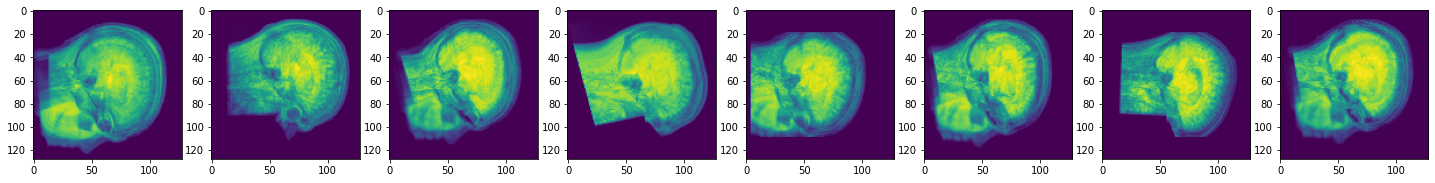

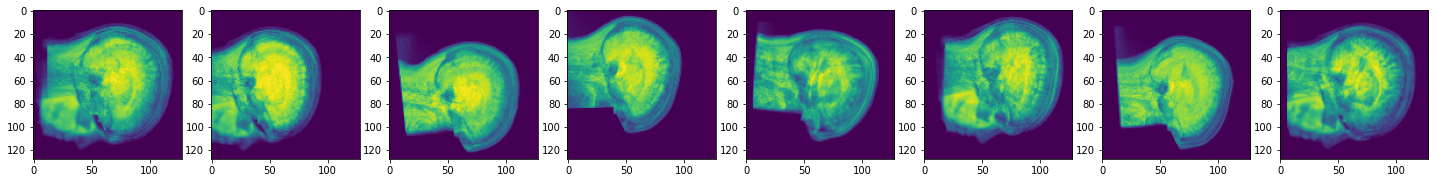

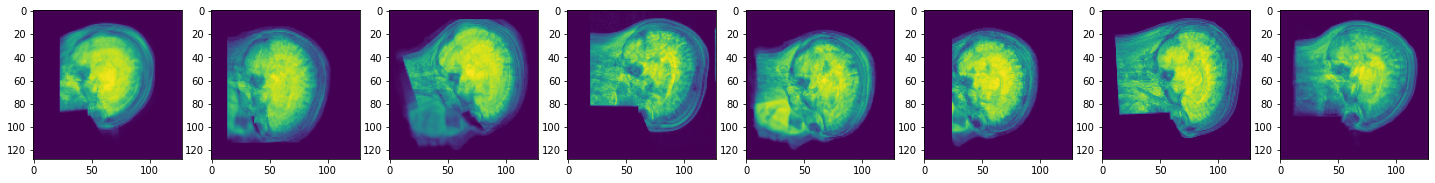

In [9]:
import matplotlib.pyplot as plt

# x, y = next(ds.as_numpy_operator())
# print(x.shape, y)
times = 0
for x, y in ds.as_numpy_iterator():
    if times == 3:
        break
    print(x.shape, y)
    times += 1
    
    fig = plt.figure(figsize=(25, 8))
    
    for i in range(1, 9):
        fig.add_subplot(1,8, i)
        plt.imshow(x[i-1, :, :])
    
#     all_imgs = []
#     for i in range(len(batch_predictions)):
#         if batch_predictions.flatten()[i] != y.flatten()[i].astype(int):
#             incorr += 1
#             print("Predicted: ",batch_predictions.flatten()[i], "Actual: ", y.flatten()[i].astype(int))
#         else:
#             corr += 1
            
#             fig = plt.figure(figsize=(25, 8))
#             rows, cols = 3, 16
            
#             for i in range(1, cols*rows + 1):
# #                 if i/cols == 1:
# #                     use = x['coronal']
# #                 if i/cols == 2:
# #                     use = x['sagittal']
                    
#                 fig.add_subplot(rows, cols, i)
                
#                 plt.imshow(use[(i-1)%cols,:,:, 0])


#             plt.show()